In [273]:
import pandas as pd
import numpy as np
import geopy.distance
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
acoustic_1 = pd.read_csv('Data\Acoustic_578-1019-2015208.csv', header=0)
biotic_1 = pd.read_csv('Data\Biotic_578-1019-2015208.csv', header=0)

In [336]:
print(acoustic_1.iloc[1])
# print(biotic_1.iloc[2])

Data                                           Data
Header                                       Record
LogDistance                                 14.9995
LogTime                         2015-07-10 15:34:53
LogLatitude                                 60.4086
LogLongitude                                3.07694
LogOrigin                                     start
LogLatitude2                                    NaN
LogLongitude2                                   NaN
LogOrigin2                                      NaN
LogValidity                                       V
LogBottomDepth                               123.72
SampleChannelDepthUpper                          10
SampleChannelDepthLower                          20
SamplePingAxisInterval                            1
SamplePingAxisIntervalType                 distance
SamplePingAxisIntervalUnit                      nmi
SampleSvThreshold                               -82
InstrumentID                                 ID_F38
CalibrationI

In [57]:
a_columns = ['LogTime', 'LogLatitude', 'LogLongitude']
b_columns = ['HaulStartTime', 'HaulDuration', 'HaulValidity', 'HaulStartLatitude', 'HaulStartLongitude', 'HaulStopLatitude', 'HaulStopLongitude', 'HaulDistance', 'HaulTowDirection']

acoustic_1_1 = acoustic_1[a_columns]
biotic_1_1 = biotic_1[b_columns]

In [58]:
print(acoustic_1_1)
# print(biotic_1_1.iloc[0])

                   LogTime  LogLatitude  LogLongitude
0      2015-07-10 15:34:53      60.4086       3.07694
1      2015-07-10 15:34:53      60.4086       3.07694
2      2015-07-10 15:34:53      60.4086       3.07694
3      2015-07-10 15:34:53      60.4086       3.07694
4      2015-07-10 15:34:53      60.4086       3.07694
...                    ...          ...           ...
43584  2015-07-10 11:52:25      60.4093       3.02920
43585  2015-07-10 11:52:25      60.4093       3.02920
43586  2015-07-10 11:52:25      60.4093       3.02920
43587  2015-07-10 11:52:25      60.4093       3.02920
43588  2015-07-10 11:52:25      60.4093       3.02920

[43589 rows x 3 columns]


C:\Users\MarkR\AppData\Local\Temp\ipykernel_11936\434596950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acoustic_1_1['LogTime'] = pd.to_datetime(acoustic_1_1['LogTime'])
C:\Users\MarkR\AppData\Local\Temp\ipykernel_11936\434596950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biotic_1_1['HaulStartTime'] = pd.to_datetime(biotic_1_1['HaulStartTime'])


In [98]:
acoustic_1_1['LogTime'] = pd.to_datetime(acoustic_1_1['LogTime'])
biotic_1_1['HaulStartTime'] = pd.to_datetime(biotic_1_1['HaulStartTime'])
acoustic_1_1 = acoustic_1_1.drop_duplicates()

bio_to_aco = biotic_1_1[['HaulStartTime', 'HaulStartLatitude', 'HaulStartLongitude']]
bio_to_aco = bio_to_aco.rename(columns={'HaulStartTime': 'LogTime', 'HaulStartLatitude': 'LogLatitude', 'HaulStartLongitude': 'LogLongitude'})

acoustic_final = pd.concat([acoustic_1_1, bio_to_aco], ignore_index=True)
acoustic_final = acoustic_final.sort_values('LogTime', ignore_index=True)

acoustic_final2 = acoustic_final.set_index('LogTime')
biotic_final = biotic_1_1.set_index('HaulStartTime')

                 LogTime  LogLatitude  LogLongitude
0    2015-06-27 05:09:43      56.6593       5.99938
1    2015-06-27 05:16:27      56.6574       5.96831
2    2015-06-27 05:22:55      56.6574       5.93521
3    2015-06-27 05:29:39      56.6580       5.90191
4    2015-06-27 05:36:18      56.6587       5.86881
...                  ...          ...           ...
2343 2015-07-25 03:54:17      57.9402       0.75630
2344 2015-07-25 06:25:35      57.8488       1.29730
2345 2015-07-25 09:53:15      58.3079       1.61790
2346 2015-07-25 12:57:59      58.7577       1.61940
2347 2015-07-25 16:55:58      59.2865       1.80020

[2348 rows x 3 columns]


In [ ]:
full_set = acoustic_final2.join(biotic_final)


full_set['fishing'] = 0

full_set.loc[full_set['HaulValidity'] == 'V', 'fishing'] = 1
full_set = full_set.drop('HaulValidity', axis=1)
full_set = full_set.iloc[full_set.index < '2015-07-16 00:00:00']
 
time_str = '1/1/1900 12:00:00.0000'
date_format_str = '%d/%m/%Y %H:%M:%S.%f'

track = 1
start_haul = datetime.strptime(time_str, date_format_str)
end_haul = datetime.strptime(time_str, date_format_str)
index = full_set.index
while track < full_set.shape[0]:
    if full_set['HaulDuration'][track] > 0:
        start_haul = index[track]
        end_haul = index[track] + timedelta(minutes=full_set['HaulDuration'][track])
    
    if index[track] >= start_haul and index[track] <= end_haul:
        full_set['fishing'][track] = 1
    track += 1

full_set = full_set[['LogLatitude', 'LogLongitude', 'fishing']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full_set)

In [243]:
distances = [0]
durations = [0]

index = full_set.index
i=0
while i < full_set.shape[0] - 1:
    distances.append(geopy.distance.distance((full_set['LogLatitude'][i], full_set['LogLongitude'][i]), (full_set['LogLatitude'][i+1], full_set['LogLongitude'][i+1])).km)
    durations.append((index[i+1] - index[i]).total_seconds())
    i += 1

km_s = [0]
j=1
while j < len(distances):
    km_s.append((distances[j]/durations[j]) * 60 * 60)
    j += 1


In [ ]:
full_set['speed'] = km_s

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full_set)

In [261]:
full_x = full_set[['speed']]
full_y = full_set['fishing']

In [332]:
# X_train, X_test, y_train, y_test = train_test_split(full_x, full_y,
#                                                 stratify=full_y, 
#                                                 test_size=0.25)

X_train = full_x.head(round(full_x.shape[0]*0.7))
y_train = full_y.head(round(len(full_y)*0.7))

X_test = full_x.tail(round(full_x.shape[0]*0.3))
y_test = full_y.tail(round(len(full_y)*0.3))

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

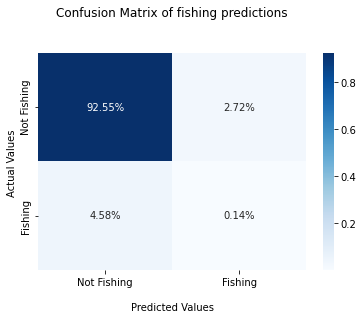

In [333]:
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix of fishing predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not Fishing','Fishing'])
ax.yaxis.set_ticklabels(['Not Fishing','Fishing'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
full_test = X_test
full_test['y_test'] = y_test.tolist()
full_test['y_pred'] = y_pred
y_proba = pd.DataFrame(y_proba)
full_test['y_proba 0'] = y_proba[0].tolist()
full_test['y_proba 1'] = y_proba[1].tolist()

In [335]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full_test)

,speed,y_test,y_pred,y_proba 0,y_proba 1
LogTime,,,,,
2015-07-07 15:57:48,18.324192,0,0,0.991052,0.008948
2015-07-07 16:04:29,18.276388,0,0,0.990917,0.009083
2015-07-07 16:11:10,18.279112,0,0,0.990925,0.009075
2015-07-07 16:17:47,18.455405,0,0,0.991411,0.008589
2015-07-07 16:24:24,18.460050,0,0,0.991424,0.008576
2015-07-07 16:31:05,18.231570,0,0,0.990789,0.009211
2015-07-07 16:59:48,6.876360,1,0,0.750541,0.249459
2015-07-07 17:55:24,1.444372,0,1,0.352182,0.647818
2015-07-07 18:01:56,18.592808,0,0,0.991772,0.008228


,0,1
0,0.739803,0.260197
1,0.840414,0.159586
2,0.994597,0.005403
3,0.993990,0.006010
4,0.991663,0.008337
...,...,...
577,0.991273,0.008727
578,0.978377,0.021623
579,0.994186,0.005814
580,0.743120,0.256880
